In [2]:
%pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 3.7/150.0 MB 19.8 MB/s eta 0:00:08
   -- ------------------------------------- 7.9/150.0 MB 19.5 MB/s eta 0:00:08
   --- ------------------------------------ 11.5/150.0 MB 19.0 MB/s eta 0:00:08
   --- ------------------------------------ 14.2/150.0 MB 17.4 MB/s eta 0:00:08
   ---- ----------------------------------- 17.0/150.0 MB 16.5 MB/s eta 0:00:09
   ----- ---------------------------------- 19.7/150.0 MB 15.9 MB/s eta 0:00:09
   ------ --------------------------------- 22.5/150.0 MB 15.7 MB/s eta 0:00:09
   ------ --------------------------------- 25.2/150.0 MB 15.2 MB/s eta 0:00:09
   ------- -------------------------------- 27.3/150.0 MB 14.5 MB/s eta 0:00:09
   -------- ------------------------------- 30.4/150.0 MB 14.5 MB/s eta 0:00:09
   -------- ------------------------------- 33.6/150.0 MB 14.7 MB/s eta 0:00:08
   --------- ------------------------------ 36.7/15


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import delta_sharing
import os
from pyspark.sql import SparkSession
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

In [5]:
df = pd.read_csv("data_sets/almost_full_data4.csv")
df_tmp = df.iloc[:1000000]
df_test = df.iloc[1000000:1500000]

In [11]:
df_tmp = df.iloc[3000000:6000000]

In [12]:
print(df_tmp["Error_Status_Cloud"].value_counts())

0.0       2536557
64.0       122482
256.0       50946
16.0        44025
3076.0      38838
4.0         36435
1028.0      21864
36.0        19583
1031.0      10399
3332.0       9225
128.0        1627
192.0        1465
260.0          71
576.0          31
292.0          22
512.0          16
548.0          15
768.0          10
7.0             5
20.0            5
2048.0          2
8.0             1
1284.0          1
Name: Error_Status_Cloud, dtype: int64


In [39]:
bit_position = 5
df_tmp.dropna(subset=["Error_Status_Cloud"], inplace=True)
df_tmp["bit_6"] = df_tmp["Error_Status_Cloud"].apply(lambda x: (int(x) >> bit_position) & 1)

In [13]:
#basic data cleaning

bit_position = 6
df_tmp.dropna(subset=["Error_Status_Cloud"], inplace=True)
df_tmp["bit_6"] = df_tmp["Error_Status_Cloud"].apply(lambda x: (int(x) >> bit_position) & 1)
df_tmp["error_in_next_30_days"] = 0

df_tmp["day_difference_from_first"] = 0  # ! what does this do?

# Reference time from row 0
time_zero = df_tmp["sample_time"].iloc[0]

df_tmp["sample_time"] = pd.to_datetime(df_tmp["sample_time"], errors='coerce')
df_tmp["day_difference_from_first"] = (df_tmp["sample_time"] - df_tmp["sample_time"].iloc[0]).dt.days

df_tmp = df_tmp.sort_values(by=["device_id", "sample_time"], ascending=[True, True])


#adding error_in_next_2_days column

bit_6 = df_tmp["bit_6"].to_numpy()
device_id = df_tmp["device_id"].to_numpy()
sample_time = df_tmp["sample_time"].to_numpy()
day_difference = df_tmp["day_difference_from_first"].to_numpy()
error_flag = np.zeros(len(df_tmp), dtype=int)  # Initialize the target column as a NumPy array

# Iterate efficiently with NumPy
for i in tqdm(range(len(df_tmp) - 1, -1, -1), desc="Processing rows"):
    if bit_6[i] == 1:
        curID = device_id[i]
        latest_day = i
        
        # Find indices where device_id matches & day difference is within 2 days
        mask = (device_id == curID) & (day_difference > day_difference[latest_day] - 2) & (day_difference < day_difference[latest_day])
        error_flag[mask] = 1  # Set error flag for all matching rows

df_tmp["error_in_next_2_days"] = error_flag  # Assign the optimized result back to DataFrame


#adding rolling average columns

# Step 1: Calculate the daily average for each device
df_daily_avg = df_tmp.groupby(["device_id", "day_difference_from_first"]).agg(
    avg_DeltaT_K=("DeltaT_K", "mean"),
    avg_Flow_Volume_total_m3=("Flow_Volume_total_m3", "mean")
).reset_index()

# Step 2: Sort data correctly
df_daily_avg.sort_values(by=["device_id", "day_difference_from_first"], inplace=True)

'''
# Step 3: Apply rolling window (without "on=")
df_daily_avg["rolling_avg_DeltaT_K"] = (
    df_daily_avg.groupby("device_id")["avg_DeltaT_K"]
    .rolling(7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

df_daily_avg["rolling_avg_Flow_Volume_total_m3"] = (
    df_daily_avg.groupby("device_id")["avg_Flow_Volume_total_m3"]
    .rolling(7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Step 4: Merge rolling averages back into the original DataFrame
df_tmp = df_tmp.merge(
    df_daily_avg[["device_id", "day_difference_from_first", "rolling_avg_DeltaT_K", "rolling_avg_Flow_Volume_total_m3"]],
    on=["device_id", "day_difference_from_first"],
    how="left"
)
'''
# Select relevant numeric columns for rolling average calculation
rolling_columns = [
    "T1_remote_K", "T2_embeded_K", "RelFlow_Fb_Rel2Vmax", "RelPower_Fb_Rel2Pmax", 
    "AbsFlow_Fb_m3s", "AbsPower_Fb_W", "Heating_E_J", "Glycol_Concentration_Rel",
    "Cooling_E_J", "RelPos_Fb", "DeltaT_Limitation_Write", "SpDeltaT_K_Write", 
    "Pmax_Rel_Write", "Vmax_Rel_Write", "SpFlow_DeltaT_lmin_Write", "DDC_Sp_Rel",
    "SpDeltaT_applied_K", "DDC_BUS_Sp_Write", "dT_Manager_Ste", "Active_dT_Manager_total_h",
    "DeltaT_K", "DDC_Sp_V", "OperatingHours", "Flow_Volume_total_m3", "Y3AnalogInputValue"
]

# Step 1: Calculate daily averages for each relevant column
df_daily_avg = df_tmp.groupby(["device_id", "day_difference_from_first"])[rolling_columns].mean().reset_index()

# Step 2: Apply rolling average (7-day window) for each column
df_daily_avg = df_daily_avg.sort_values(by=["device_id", "day_difference_from_first"])

# Apply rolling mean grouped by device_id
for col in rolling_columns:
    df_daily_avg[f"rolling_avg_{col}"] = (
        df_daily_avg.groupby("device_id")[col]
        .rolling(2, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Step 3: Merge rolling averages back into df_tmp
rolling_avg_columns = [f"rolling_avg_{col}" for col in rolling_columns]

df_tmp = df_tmp.merge(
    df_daily_avg[["device_id", "day_difference_from_first"] + rolling_avg_columns],
    on=["device_id", "day_difference_from_first"],
    how="left"
)

df_tmp["error_in_next_2_days"] = df_tmp["error_in_next_2_days"].fillna(0)


C:\Users\Filip\AppData\Local\Temp\ipykernel_36436\3547204454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.dropna(subset=["Error_Status_Cloud"], inplace=True)
C:\Users\Filip\AppData\Local\Temp\ipykernel_36436\3547204454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["bit_6"] = df_tmp["Error_Status_Cloud"].apply(lambda x: (int(x) >> bit_position) & 1)
C:\Users\Filip\AppData\Local\Temp\ipykernel_36436\3547204454.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [14]:
df_tmp.to_csv("preprocessed_data.csv", index=False)

In [9]:
print(df_tmp["error_in_next_2_days"].value_counts())

0    999898
Name: error_in_next_2_days, dtype: int64


In [5]:
df_tmp = pd.read_csv("preprocessed_data.csv")       

In [6]:
df_test = pd.read_csv("preprocessed_test_data.csv")

In [7]:
#X_train, X_test, y_train, y_test = train_test_split(df_tmp[['rolling_avg_DeltaT_K', 'rolling_avg_Flow_Volume_total_m3']],df_tmp["error_in_next_2_days"], test_size=0.25, random_state=42)
# Select all rolling average columns dynamically
rolling_avg_features = [col for col in df_tmp.columns if col.startswith("rolling_avg_")]

# Ensure no NaN values in features
df_tmp[rolling_avg_features] = df_tmp[rolling_avg_features].fillna(0)

# Split features (X) and target variable (y)
X = df_tmp[rolling_avg_features]
y = df_tmp["error_in_next_2_days"]

ratio = len(df_tmp[df_tmp['error_in_next_2_days'] == 0]) / len(df_tmp[df_tmp['error_in_next_2_days'] == 1])

# Train XGBoost Model
model = xgb.XGBClassifier(
    #scale_pos_weight=ratio,
    n_estimators=1000, 
    max_depth=25, 
    learning_rate=0.01,
    subsample=0.8, 
    colsample_bytree=0.8, 
    use_label_encoder=False,
    eval_metric="logloss"
)

# Fit the model
model.fit(X, y)

c:\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [22:42:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [26]:
#repeat same steps for test data

df_tmp = df.iloc[1500000:2000000] 

In [17]:
print(df_tmp["Error_Status_Cloud"].value_counts())

0.0       462496
16.0       17688
64.0       11534
4.0         4154
1028.0      3916
192.0         94
256.0         11
2048.0         2
512.0          1
Name: Error_Status_Cloud, dtype: int64


In [27]:
#basic data cleaning

bit_position = 6
df_tmp.dropna(subset=["Error_Status_Cloud"], inplace=True)
df_tmp["bit_6"] = df_tmp["Error_Status_Cloud"].apply(lambda x: (int(x) >> bit_position) & 1)
df_tmp["error_in_next_30_days"] = 0

df_tmp["day_difference_from_first"] = 0  # Initialize with 0

# Reference time from row 0
time_zero = df_tmp["sample_time"].iloc[0]

df_tmp["sample_time"] = pd.to_datetime(df_tmp["sample_time"], errors='coerce')
df_tmp["day_difference_from_first"] = (df_tmp["sample_time"] - df_tmp["sample_time"].iloc[0]).dt.days

df_tmp = df_tmp.sort_values(by=["device_id", "sample_time"], ascending=[True, True])


#adding error_in_next_2_days column

bit_6 = df_tmp["bit_6"].to_numpy()
device_id = df_tmp["device_id"].to_numpy()
sample_time = df_tmp["sample_time"].to_numpy()
day_difference = df_tmp["day_difference_from_first"].to_numpy()
error_flag = np.zeros(len(df_tmp), dtype=int)  # Initialize the target column as a NumPy array

# Iterate efficiently with NumPy
for i in tqdm(range(len(df_tmp) - 1, -1, -1), desc="Processing rows"):
    if bit_6[i] == 1:
        curID = device_id[i]
        latest_day = i
        
        # Find indices where device_id matches & day difference is within 2 days
        mask = (device_id == curID) & (day_difference > day_difference[latest_day] - 2) & (day_difference < day_difference[latest_day])
        error_flag[mask] = 1  # Set error flag for all matching rows

df_tmp["error_in_next_2_days"] = error_flag  # Assign the optimized result back to DataFrame


#adding rolling average columns

# Step 1: Calculate the daily average for each device
df_daily_avg = df_tmp.groupby(["device_id", "day_difference_from_first"]).agg(
    avg_DeltaT_K=("DeltaT_K", "mean"),
    avg_Flow_Volume_total_m3=("Flow_Volume_total_m3", "mean")
).reset_index()

# Step 2: Sort data correctly
df_daily_avg.sort_values(by=["device_id", "day_difference_from_first"], inplace=True)

'''
# Step 3: Apply rolling window (without "on=")
df_daily_avg["rolling_avg_DeltaT_K"] = (
    df_daily_avg.groupby("device_id")["avg_DeltaT_K"]
    .rolling(7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

df_daily_avg["rolling_avg_Flow_Volume_total_m3"] = (
    df_daily_avg.groupby("device_id")["avg_Flow_Volume_total_m3"]
    .rolling(7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Step 4: Merge rolling averages back into the original DataFrame
df_tmp = df_tmp.merge(
    df_daily_avg[["device_id", "day_difference_from_first", "rolling_avg_DeltaT_K", "rolling_avg_Flow_Volume_total_m3"]],
    on=["device_id", "day_difference_from_first"],
    how="left"
)
'''
# Select relevant numeric columns for rolling average calculation
rolling_columns = [
    "T1_remote_K", "T2_embeded_K", "RelFlow_Fb_Rel2Vmax", "RelPower_Fb_Rel2Pmax", 
    "AbsFlow_Fb_m3s", "AbsPower_Fb_W", "Heating_E_J", "Glycol_Concentration_Rel",
    "Cooling_E_J", "RelPos_Fb", "DeltaT_Limitation_Write", "SpDeltaT_K_Write", 
    "Pmax_Rel_Write", "Vmax_Rel_Write", "SpFlow_DeltaT_lmin_Write", "DDC_Sp_Rel",
    "SpDeltaT_applied_K", "DDC_BUS_Sp_Write", "dT_Manager_Ste", "Active_dT_Manager_total_h",
    "DeltaT_K", "DDC_Sp_V", "OperatingHours", "Flow_Volume_total_m3", "Y3AnalogInputValue"
]

# Step 1: Calculate daily averages for each relevant column
df_daily_avg = df_tmp.groupby(["device_id", "day_difference_from_first"])[rolling_columns].mean().reset_index()

# Step 2: Apply rolling average (7-day window) for each column
df_daily_avg = df_daily_avg.sort_values(by=["device_id", "day_difference_from_first"])

# Apply rolling mean grouped by device_id
for col in rolling_columns:
    df_daily_avg[f"rolling_avg_{col}"] = (
        df_daily_avg.groupby("device_id")[col]
        .rolling(2, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Step 3: Merge rolling averages back into df_tmp
rolling_avg_columns = [f"rolling_avg_{col}" for col in rolling_columns]

df_tmp = df_tmp.merge(
    df_daily_avg[["device_id", "day_difference_from_first"] + rolling_avg_columns],
    on=["device_id", "day_difference_from_first"],
    how="left"
)

df_tmp["error_in_next_2_days"] = df_tmp["error_in_next_2_days"].fillna(0)


C:\Users\Filip\AppData\Local\Temp\ipykernel_36436\1253856763.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.dropna(subset=["Error_Status_Cloud"], inplace=True)
C:\Users\Filip\AppData\Local\Temp\ipykernel_36436\1253856763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["bit_6"] = df_tmp["Error_Status_Cloud"].apply(lambda x: (int(x) >> bit_position) & 1)
C:\Users\Filip\AppData\Local\Temp\ipykernel_36436\1253856763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [ ]:
df_tmp.to_csv("preprocessed_test_data.csv", index=False)

In [30]:
df_tmp = pd.read_csv("preprocessed_data.csv")

In [8]:
# Select all rolling average features dynamically
rolling_avg_features = [col for col in df_tmp.columns if col.startswith("rolling_avg_")]

# Ensure no missing values in feature columns before prediction
df_test[rolling_avg_features] = df_test[rolling_avg_features].fillna(0)

# Make predictions using the trained model
y_pred = model.predict(df_test[rolling_avg_features])

# Compute classification report
report = classification_report(df_test['error_in_next_2_days'], y_pred)

# Print results
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    487510
           1       0.71      0.08      0.14     12386

    accuracy                           0.98    499896
   macro avg       0.84      0.54      0.57    499896
weighted avg       0.97      0.98      0.97    499896



In [21]:
df_test = pd.read_csv("preprocessed_test_data.csv")

In [43]:

df_test["predicted_error_next_2_days"] = y_pred
df_filtered = df_test[df_test["error_in_next_2_days"] == df_test["predicted_error_next_2_days"]]


In [44]:
df_filtered.tail()

# print(df_filtered.columns)

df_filip_cook = df_filtered.groupby("device_id")["bit_6"].sum().reset_index()
df_filip_cook = df_filip_cook.rename(columns={"bit_6": "total_errors"})
print(df_filip_cook.sort_values("total_errors", ascending=False))


                               device_id  total_errors
7   65679ea6-440f-437f-9986-7cb371c5b222          1553
0   0edd17b9-1c37-4eec-a760-83e1f1c30011          1427
4   3f7b5687-0a94-4940-ba7f-3029e918e8d7           279
27  c6569cbb-ab19-41bd-97b8-4a60651ab3b4           172
18  7c4650f5-f6a8-4c0e-978f-6d3edec3be8d             1
28  d052759e-955d-4abd-9663-362a5f2961c4             0
29  f77f38f1-8889-4c6a-8efb-4226f7cfde6f             0
30  f88446ee-5189-4196-867b-cdff22ee852c             0
17  7bcf3c64-f0d6-4326-aca6-0dc085150a1d             0
25  c3225fd7-d939-401e-975c-0f7c12cea169             0
24  be3fe009-ac7c-4bfc-a973-4a792c0e2e0c             0
23  bd4f0d1e-edd5-4d44-923a-daaedcbcaad2             0
22  bce9c1ad-cba9-4be2-8b10-fa4d6a155793             0
21  aa36a1fe-fa55-4d27-970d-c791db750b9f             0
20  aa0313d6-285a-436c-a92f-4ba662ac3982             0
19  a9378bdf-e6ea-426d-81e1-87cb2670129e             0
26  c5ca3fc9-bf93-4de1-ac0c-853e8043c5ba             0
16  7baa9b

In [45]:
df_filtered = df_filtered[df_filtered["device_id"] == "c6569cbb-ab19-41bd-97b8-4a60651ab3b4"].head(50000)

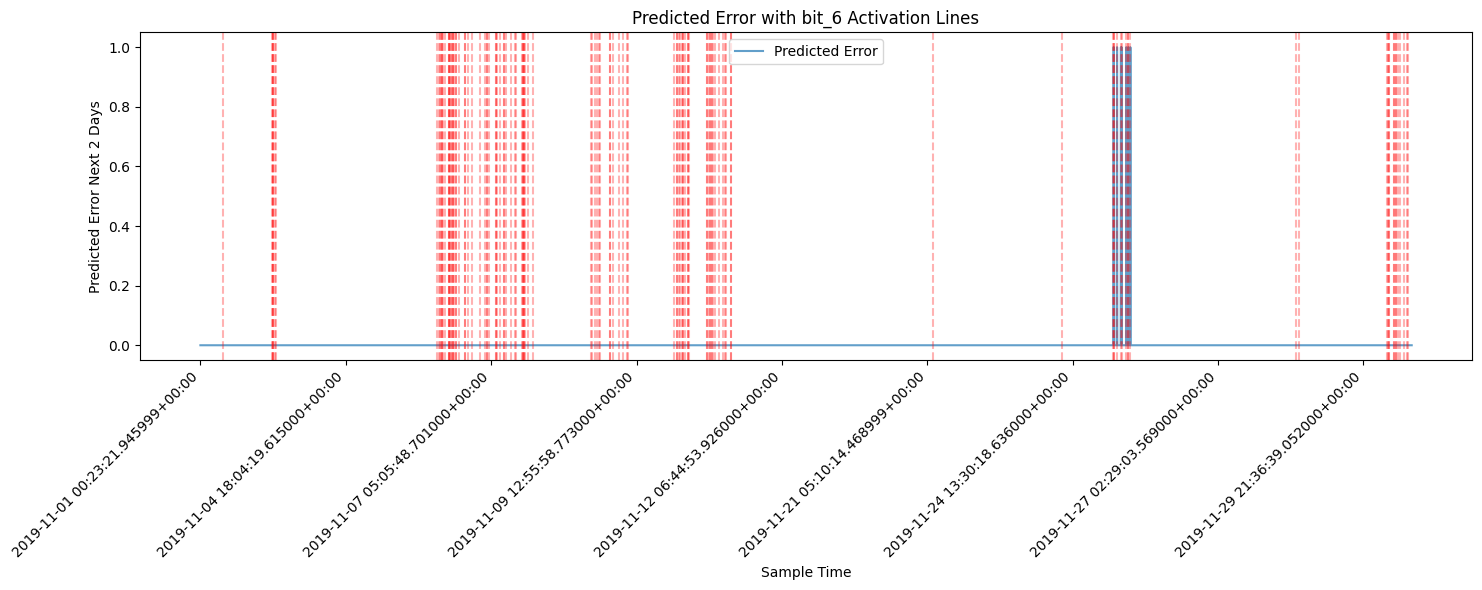

In [46]:

# Sample and sort
df_filtered = df_test.sample(5000)
df_filtered = df_filtered.sort_values("sample_time")

plt.figure(figsize=(15, 6))

# Line plot: sample_time on x-axis, predicted_error_next_2_days on y-axis
plt.plot(df_filtered['sample_time'], df_filtered['predicted_error_next_2_days'], label='Predicted Error', alpha=0.7)

# Add vertical lines where bit_6 == 1
bit_6_sample_times = df_filtered[df_filtered['bit_6'] == 1]['sample_time']
for t in bit_6_sample_times:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.3)

# Set x-axis label formatting and spacing
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))  # Limit to ~10 x-ticks
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability

plt.legend()
plt.title('Predicted Error with bit_6 Activation Lines')
plt.xlabel('Sample Time')
plt.ylabel('Predicted Error Next 2 Days')
plt.tight_layout()
plt.show()
